In [ ]:
#Download the nltk packages 
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

True

In [ ]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#import data
train_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Hate_Speech/train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#A quick peep at the data
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
#import data
test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Hate_Speech/test_tweets.csv")

In [ ]:
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
#From the above dataset, there is a label column for the train data and none for the test data

#check for the sum of hate tweets and non-hate tweets

sum(train_data["label"]==1)

2242

In [ ]:
sum(train_data["label"]==0)

29720

**Exploratory Data Analysis**

In [ ]:
#Check the data for missing values or duplicates or empty cells

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
train_data.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [ ]:
train_data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [ ]:
#Our focus is analyzing the tweets, hence we look at a sample
train_data['tweet'][0]


' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [ ]:
train_data['tweet'][1]

"@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"

Data Cleaning

In [ ]:
#install tweet-preprocessor library to clean tweets

!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import preprocessor as p
REPLACE_NO_SPACE = re.compile("[^a-zA-Z]http\S+\s*RT|cc#\S+@user\S+!\s+")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

In [ ]:
def processed_tweets(train_data):
  subArr = []
  for line in train_data:
    #remove punctuation
    tweet = p.clean(line)
    tweet = REPLACE_NO_SPACE.sub("", tweet.lower())
    tweet = REPLACE_WITH_SPACE.sub(" ", tweet)
    subArr.append(tweet)
  return subArr

In [ ]:
#cleaning the training data

train_data.tweet = processed_tweets(train_data["tweet"])

In [ ]:
train_data

,id,label,tweet
0,1,0,when a father is dysfunctional and is so selfi...
1,2,0,thanks for credit i can't use cause they don't...
2,3,0,bihday your majesty
3,4,0,i love u take with u all the time in ur!!!
4,5,0,factsguide society now
...,...,...,...
31957,31958,0,ate isz that youuu?
31958,31959,0,to see nina turner on the airwaves trying to w...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"vandalised in in , condemns act"


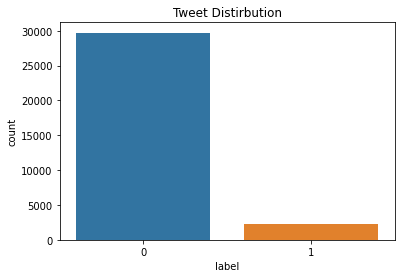

In [ ]:
#Visualize the Hate Speech distribution

sns.countplot(train_data['label'])
plt.title('Tweet Distirbution')
plt.show()

In [ ]:
#Considering our training data is imbalanced we will upsample '0' in training set. This will remove every unbiased distribution in the training
from sklearn.utils import resample

#Seperating the the classes 
train_0 = train_data[train_data['label']==0]
train_1 = train_data[train_data['label']==1]

In [ ]:
#Shape of the separated classes
train_0.shape, train_1.shape

((29720, 3), (2242, 3))

In [ ]:
#Creatoing a function to resample
upsampled_train_1 = resample(train_1,
                             replace=True,
                             n_samples=25760,
                             random_state=185
                            )
upsampled_train_1.shape

(25760, 3)

In [ ]:
#Now let us merge the resampled 1 with the other majority unsampled class 
upsampled_train = pd.concat([train_0, upsampled_train_1])
ut_df = pd.DataFrame(upsampled_train)
ut_df

,id,label,tweet
0,1,0,when a father is dysfunctional and is so selfi...
1,2,0,thanks for credit i can't use cause they don't...
2,3,0,bihday your majesty
3,4,0,i love u take with u all the time in ur!!!
4,5,0,factsguide society now
...,...,...,...
16227,16228,1,"+ = same from , different color of skin but sa..."
6102,6103,1,will the alt right promote a new kind of genet...
3017,3018,1,self defense for women course
5197,5198,1,this is beyond upsetting. i was one of her big...


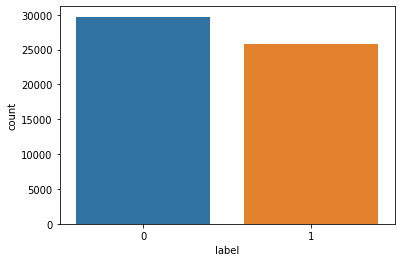

In [ ]:
#Let us see if they are balanced now
sns.countplot('label', data=ut_df)

In [ ]:
ut_df.head()

,id,label,tweet
0,1,0,when a father is dysfunctional and is so selfi...
1,2,0,thanks for credit i can't use cause they don't...
2,3,0,bihday your majesty
3,4,0,i love u take with u all the time in ur!!!
4,5,0,factsguide society now


In [ ]:
ut_df.tail()

,id,label,tweet
16227,16228,1,"+ = same from , different color of skin but sa..."
6102,6103,1,will the alt right promote a new kind of genet...
3017,3018,1,self defense for women course
5197,5198,1,this is beyond upsetting. i was one of her big...
9762,9763,1,are &amp; feel like the are stomping on you? l...


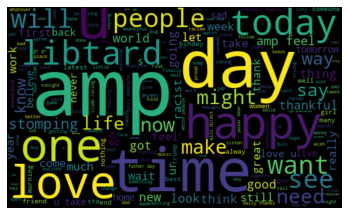

In [ ]:
#Plotting the word cloud for visualization of the more specific words used in the tweets

from wordcloud import WordCloud

allwords = ''.join([tweets for tweets in ut_df['tweet']])
wordCloud = WordCloud(width = 500, height=300, random_state =21, max_font_size = 119).generate(allwords)

plt.imshow(wordCloud, interpolation = "bilinear")

plt.axis('off')
plt.show()

In [ ]:
#Clean the test data by applying the function to it

test_data.tweet = processed_tweets(test_data["tweet"])

In [ ]:
test_data.head()

,id,tweet
0,31963,to find
1,31964,want everyone to see the new and heres why
2,31965,safe ways to heal your !! !!
3,31966,is the hp and the cursed child book up for res...
4,31967,"rd to my amazing, hilarious eli ahmir! uncle d..."


In [ ]:
#Split the Data into Training and testing uusng split function call

#Define the Independent, x and dependent variables y

x = train_data.tweet.values
y = train_data.label.values



In [ ]:
#Split the data

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 42, test_size= 0.2, shuffle=True)

In [ ]:
#Vectorize tweets using Count Vectorizer
vectorizer = TfidfVectorizer()

vectorizer.fit(list(x_train) + list(x_test))

x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_test)


In [ ]:
#Model Building

#classify the document using Logistic Regression

log = LogisticRegression()

In [ ]:
#fit the model on the train data

prob = log.fit(x_train_vec, y_train).predict_proba(x_test_vec)

In [ ]:
#perform classification and prediction on samples in x_test

y_pred_log = log.predict(x_test_vec)

In [ ]:
#Accuracy

print("Accuracy score for Log is: ", accuracy_score(y_test, y_pred_log) * 100, '%')

Accuracy score for Log is:  94.22806194274989 %


In [ ]:
example = test_data["tweet"]
example_vec = vectorizer.transform(example)
result = log.predict(example_vec)

In [ ]:
result

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
res = pd.DataFrame(result)

In [ ]:
res

,0
0,0
1,0
2,0
3,0
4,0
...,...
17192,1
17193,0
17194,0
17195,0


In [ ]:
test_data['result'] = result.tolist()

#display the DataFrame
print(test_data)

          id                                              tweet  result
0      31963                                            to find       0
1      31964         want everyone to see the new and heres why       0
2      31965                       safe ways to heal your !! !!       0
3      31966  is the hp and the cursed child book up for res...       0
4      31967  rd to my amazing, hilarious eli ahmir! uncle d...       0
...      ...                                                ...     ...
17192  49155     thought factory left right polarisation! &gt;3       1
17193  49156                             feeling like a mermaid       0
17194  49157  today in ((omg)) &amp; used words like "assets...       0
17195  49158  happy, at work conference right mindset leads ...       0
17196  49159                   my song "so glad" free download!       0

[17197 rows x 3 columns]


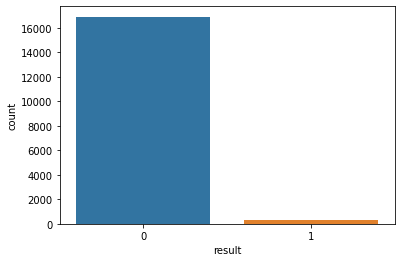

In [ ]:
sns.countplot('result', data=test_data)

In [ ]:
#Using Transformer

!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ktrain import text

In [ ]:
model = 'distilbert-base-uncased'

trans = text.Transformer(model, maxlen=256)

In [ ]:
model_predict = trans.preprocess_train(x_train, y_train)
model_predict1 = trans.preprocess_test(x_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 25


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:723: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  + "If this is incorrect, change accordingly."


preprocessing test...
language: en
test sequence lengths:
	mean : 10
	95percentile : 21
	99percentile : 25


In [ ]:
mymodel = trans.get_classifier()

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:1203: UserWarning: no class labels were provided - treating as regression
  warnings.warn("no class labels were provided - treating as regression")


In [ ]:
import ktrain
learn_the_data = ktrain.get_learner(mymodel, train_data = (x_train, y_train), batch_size = 32)

mymodel.summary()


Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,954,241
Trainable params: 66,954,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = learn_the_data.fit_onecycle(1e-1, 1)



begin training using onecycle policy with max lr of 0.1...


TypeError: ignored